# Projeto 1 - MC886

## Objetivo
Aplicar métodos de Aprendizado Não Supervisionado para resolver problemas de clusterização e redução de dimensionalidade em duas tarefas:
<ul>
    <li>Uma tarefa 2D (utilizando os dados fornecidos)</li>
    <li>Uma tarefa com mais dimensões especificada pelo grupo (sendo necessário descrever o problema escolhido, as features utilizadas e o tamanho do dataset)</li>

## Parte 1 - Métodos de Clusterização
Nesta tarefa, implementamos os algoritmos K-Means e **X** utilizando os conceitos dados em aula e outras referências.
Após a implementação, nos organizamos para treinar nosso modelo, e realizamos os seguintes procedimentos:
<ul>
    <li>Normalizamos os dados para tratar as diferenças de escala entre nossas features</li>
    <li>Separamos nosso conjunto de dados entre treino e teste (90/10)</li>
    <li>Treinamos os métodos na tarefa 2D com os dados fornecidos</li>
    <li>Treinamos os métodos na tarefa selecionada pelo grupo</li>
    <li>Avaliamos números diferentes de clusteres nas tarefas, e seu impacto para escolher a melhor configuração para nossos modelos </li>
    <li>Utilizamos métricas apropriadas para avaliar os experimentos</li>
    <li>Escolhemos os melhores modelos e aplicamos os dados de testes. Mostramos para quais clusteres os novos dados foram designados</li>
</ul>


### Tarefa selecionada
&emsp;Para esta tarefa escolhemos o problema que envolve resultados uma análise química de vinhos, cultivados numa mesma região da Itália mas que derivam de 3 vinículas diferentes.\
&emsp;A análise determina as quantidades de 13 constituentes encontrados nos vinhos, que são:\
&emsp;&emsp;&emsp;Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315, Proline.\
    Fonte: https://towardsdatascience.com/k-means-clustering-of-wine-data-95bac074baae        
    Dataset disponivel no Kaggle: https://www.kaggle.com/harrywang/wine-dataset-for-clustering

In [76]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from random import *
import pandas as pd
import sys
from scipy.cluster.hierarchy import dendrogram

# Separar dataset entre treino e teste

# importa dataset cluster.dat
def import_dataset():
    with open('cluster.dat') as binary_file:
        data = []
        x = []
        y = []
        for d in binary_file:
            string = d.split()
            x.append(float(string[0]))
            y.append(float(string[1]))
    array = np.ndarray(shape=(len(x), 2), dtype=float)
    for i in range(len(x)):
        array[i][0] = x[i]
        array[i][1] = y[i]
    return array




def import_wine_dataset():
    wine_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']
    wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names = wine_names) 
    wine_df = pd.DataFrame(wine_data)
    wine_df.Class = wine_df.Class - 1 # formata a coluna "Class"

    # wine_df.plot.scatter(x = 'Alcohol', y = 'OD280/OD315', c= 'Class', figsize=(12,8), colormap='jet')
    # show()
    # print(wine_df.to_numpy())
    X_wine = wine_df[['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']]
    Y_wine = wine_df[['Class']]
    return X_wine.to_numpy(), Y_wine.to_numpy()

In [77]:
# Normaliza dados dos dois datasets

X_array = import_dataset()
W_array, W_array_y = import_wine_dataset()

scaler = StandardScaler()

scaler.fit(X_array)
scaler.mean_
X_array = scaler.transform(X_array)

scaler.fit(W_array_x)
scaler.mean_
W_array = scaler.transform(W_array)

In [96]:
# Separa dataset entre dados de treino e teste ( 90/10 )

X_treino, X_teste = train_test_split(X_array, test_size=0.1, random_state=42)
print(X_treino.shape)
print(X_teste.shape)

W_treino, W_teste, W_treino_y, W_teste_y = train_test_split(W_array_x, W_array_y, test_size=0.1, random_state=42)
print(W_treino.shape)
print(W_treino_y.shape)
print(W_teste.shape)
print(W_teste_y.shape)

(515, 2)
(58, 2)
(160, 13)
(160, 1)
(18, 13)
(18, 1)


### Implementação do algoritimo K-Means 

In [79]:
# funcao para calcular distancia euclidiana
def euclideanDistance(p, q):
    soma = 0
    for i in range(len(p)):
        soma += (p[i] - q[i])**2
    return np.sqrt(soma)

# funcao para calcular a qual cluster um ponto pertence
def getClusterMap(k, centroids, array):
    #initialize cluster_map
    cluster_map = {}
    for i in range(k):
        cluster_map[i] = []
    
    for p in array:
        min_dist = -1
        cluster = -1
        for c in range(len(centroids)):
            c_xy = centroids[c]
            distance = euclideanDistance(c_xy, p)
            if (min_dist == -1) or (distance < min_dist):
                min_dist = distance
                cluster = c
        cluster_map[cluster].append(p)
    
    return cluster_map

# funcao para atualizar os centroides
def getNewCentroids(clusterMap):
    new_centroids = []
    for c in clusterMap:
        points = clusterMap[c]
        
        min_sum_dist = -1
        for i in range(len(points)):
            sum_dist = 0
            for j in range(len(points)):
                sum_dist += euclideanDistance(points[i], points[j])
                
            if (min_sum_dist == -1) or (sum_dist < min_sum_dist):
                new_centroid = points[i]
                min_sum_dist = sum_dist
        new_centroids.append(new_centroid)
    
    return new_centroids
        
#funcao para plotar graficos com clusteres
def plotCluster(clusterMap):
    for c in clusterMap:
        points = clusterMap[c]
        array = np.ndarray(shape=(len(points), 2), dtype=float)
        for i in range(len(points)):
            array[i][0] = points[i][0]
            array[i][1] = points[i][1]
            
        plt.scatter(array[:,0], array[:,1])
    plt.show()
    
def plotGroundTruth(k, X, Y):
    resClusterMap = {}
    for i in range(k):
        resClusterMap[i] = []
    for i in range(len(Y)):
        resClusterMap[Y[i][0]].append(X[i])
    plotCluster(resClusterMap)

# funcao para exibir os pontos que são centroides
def printCentroids(k, centroids):
    for i in range(k):
        centroid = centroids[i]
        print(centroid)
        

def D(x, centers):
    dists = []

    for c in centers:
        dists.append(euclideanDistance(x, c))

    return np.amin(dists)

def plusPlusInitialization(k, points):
    # D(x) menor distancia ao centro mais prox
    # prob = D(x) / sum (D(x) ** 2)
    centroids = []
    # 1 - escolher 1 centro aleatoriamente
    centroids.append(points[randrange(len(points))])

    # 2 - pra cada nao escolhido calcular D(x) e a prob
    for n in range(k - 1):
        min_dist_acc = 0
        probabilities = []
        Ds = []
        for p in points:
            d = D(p, centroids)
            min_dist_acc += d ** 2
            Ds.append(d)
        for d in Ds:    
            probabilities.append(d / min_dist_acc)
        # 3 - Escolher outro ponto usando a função de prob proporcional a D(x)² - distante dos 
        #     outros centros mais prox
        centroids.append(
            points[
                np.random.choice(len(points), size = 1, p = probabilities/np.sum(probabilities))[0]
            ]
        )
        
    # 4 retornar centroides
    return centroids
    
def kmeans(k, array, n_iter=5, mode='train', fixed_centroids=[], print_info=True):
    if mode == 'train':
    # initialize centroids
        centroids = plusPlusInitialization(k, array)

        # Conseguimos uma lista com 'k' pontos para servirem de centroides iniciais
        for n in range(n_iter):
            # calculamos os clusters
            if print_info:
                printCentroids(k, centroids)
            clusterMap = getClusterMap(k, centroids, array)

            # atualizaremos nossos centroids a partir da media das dist euclid
            centroids = getNewCentroids(clusterMap)
            if print_info:
                plotCluster(clusterMap)
        clusterMap = getClusterMap(k, centroids, array)
        if print_info:
            plotCluster(clusterMap)
        return centroids,clusterMap
    if mode == 'test':
        clusterMap = getClusterMap(k, fixed_centroids, array)
        if print_info:
            plotCluster(clusterMap)
    
    
    

### Implementação do algoritmo Agglomerative Hierarchical Clustering

In [80]:
def initializeClusterMap(points):
    clusterMap = {}
    for i in range(len(points)):
        clusterMap[i] = i
    return clusterMap

def initializePointsMap(points):
    pointsMap = {}
    for i in range(len(points)):
        pointsMap[i] = [i]
    return pointsMap

def initializeDistances(points):
    distances = np.empty((len(points), len(points)))
    for i in range(len(points)):
        for j in range(len(points)):
            distances[i][j] = euclideanDistance(points[i], points[j])

    return distances
    
# pi e pj sao indices dos pontos no array
def mergeCluster(clusterMap, pointsMap, pi, pj, n):
    ci = clusterMap[pi]
    cj = clusterMap[pj]

    size = len(clusterMap)
    index = size + (size-n)

    for c in clusterMap:
        if clusterMap[c] == cj or clusterMap[c] == ci:
            clusterMap[c] = index

    #atualiza pointsMap
    ci_pts = pointsMap[ci]
    cj_pts = pointsMap[cj]
    pointsMap.pop(ci)
    pointsMap.pop(cj)
    pointsMap[index] = ci_pts + cj_pts
            
    return clusterMap, pointsMap

def updateDistance(distances, pointsMap, points, new_cluster, mode):
    # preciso atualizar a distancia entre on clusteres
    #   mas eh entre o CLUSTERES, nao os pontos. Entao como?
    if mode == "singular":
        return distances
    elif mode == "complete":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia maxima entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = max(dist)
                        distances[q][p] = max(dist)

    elif mode == "average":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia media entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                average = sum(np.array(dist)/(len(pts)*len(pointsMap[c])))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = average
                        distances[q][p] = average
                        
    return distances


def dendrogramCalc(clusterMap, i, j, min_distance):
    ci = clusterMap[i]
    cj = clusterMap[j]
    ni = 0
    nj = 0
    for c in clusterMap:
        if clusterMap[c] == ci:
            ni += 1
        if clusterMap[c] == cj:
            nj += 1
    return [ci, cj, min_distance, (ni+nj)]

def plotDendrogram(linkage_matrix):
    plt.title('Hierarchical Clustering Dendrogram')
    # Plot axis labels
    plt.xlabel('sample index')
    plt.ylabel('distance (Single Linkage)')
    # Make the dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90)
    # Show the graph
    plt.show()

def isOnSameCluster(pi, pj, clusterMap):
    if clusterMap[pi] == clusterMap[pj]:
        return True
    return False

def plotAggCluster(pointsMap, points):
    for c in pointsMap:
        c_pts = pointsMap[c]
        array = np.ndarray(shape=(len(c_pts), 2), dtype=float)
        for i in range(len(c_pts)):
            array[i][0] = points[c_pts[i]][0]
            array[i][1] = points[c_pts[i]][1]
            
        plt.scatter(array[:,0], array[:,1])
    plt.show()

def agglomerativeHierarchicalCluster(points, k, distance_mode, plot_dendrogram=True):
    clusterMap = initializeClusterMap(points) # points -> cluster    
    pointsMap = initializePointsMap(points) # cluster -> points
    distances = initializeDistances(points)
    n = len(points) # numero de clusteres
    dendrogram_matrix = []
    while n > k:
        min_distance = sys.maxsize
        b = 1
        for i in range(len(points)):
            for j in range(b, len(points)):
                if (distances[i][j] < min_distance) and (not isOnSameCluster(i, j, clusterMap)):
                    min_distance = distances[i][j]
                    min_distance_i = i
                    min_distance_j = j
                    
            b += 1
        
        cluster_config = dendrogramCalc(clusterMap, min_distance_i, min_distance_j, min_distance)
        clusterMap, pointsMap = mergeCluster(clusterMap, pointsMap, min_distance_i, min_distance_j, n)
        dendrogram_matrix.append(cluster_config)
        distances = updateDistance(distances, pointsMap, points, clusterMap[min_distance_i], distance_mode)
   
        n -= 1
    
    linkage_matrix = np.array(dendrogram_matrix)
    if plot_dendrogram:
        plotDendrogram(linkage_matrix)
    
    return pointsMap

def testAgglomerativeHierarchicalCluster(test_pts, train_pts, pointsMap):
    validationMap = initializeClusterMap(test_pts)
    for p in range(len(test_pts)):
        min_dist = sys.maxsize
        
        cluster_index = 0
        for c in pointsMap:
            dist = 0
            for cp in pointsMap[c]:
                dist += euclideanDistance(test_pts[p], train_pts[cp])
            if dist < min_dist:
                min_dist = dist
                validationMap[p] = cluster_index
            cluster_index += 1
    testPointsMap = {}
    for i in range(len(pointsMap)):
        testPointsMap[i] = []
    for p in validationMap:
        testPointsMap[validationMap[p]].append(p)

    return testPointsMap

### Função Elbow para achar o número de clusteres do KMeans

In [81]:
def distortion(centroids, clusterMap):
    soma = 0
    for k in range(len(centroids)):
        c_pts = clusterMap[k]
    for p in c_pts:
        soma += euclideanDistance(centroids[k], p)
        # print(p)
    return soma

def elbowPlot(nk, data, iter=10, kmeans_iter=10):
    means = []
    for k in range(1,nk+1):
        distortions = []
        for i in range(iter):
            centroids, clusterMap = kmeans(k, data, kmeans_iter, print_info=False)
            distortions.append(distortion(centroids, clusterMap))
        means.append(sum(np.array(distortions))/iter)
        print("Mean ", k, ": ", sum(np.array(distortions))/iter)
    plt.figure()
    plt.plot(range(1,nk+1), means, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### Verificação de número de clusteres para tarefa 2D

Mean  1 :  671.0226588530102
Mean  2 :  227.93541633013515
Mean  3 :  90.94124420855105
Mean  4 :  34.495569958956295
Mean  5 :  41.803707028643906
Mean  6 :  29.87319889739079
Mean  7 :  18.1178951258439
Mean  8 :  14.829468273281838
Mean  9 :  14.977316419401927
Mean  10 :  11.151949089562084


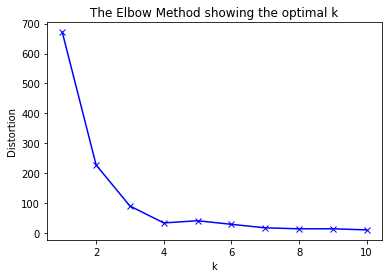

In [82]:
elbowPlot(10, X_treino, 10)

### Verificação de número de clusteres para tarefa proposta pelo grupo

Mean  1 :  38992.99024165334
Mean  2 :  11335.98465461849
Mean  3 :  4544.960646408201
Mean  4 :  2336.055643202118
Mean  5 :  1555.5011479726077
Mean  6 :  901.9431008394479
Mean  7 :  648.9950756442336
Mean  8 :  817.888353531228
Mean  9 :  628.3309797752339
Mean  10 :  266.74104195840584


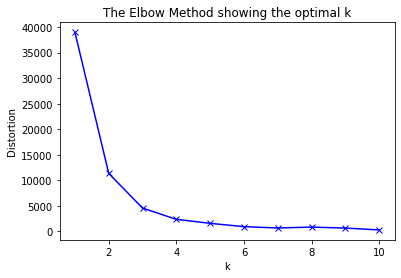

In [83]:
elbowPlot(10, W_treino, 10)

### Treinamento do Modelo K-Means

[-1.10058869  1.25795141]
[ 0.10028638 -0.92067702]
[1.35675752 0.58203345]


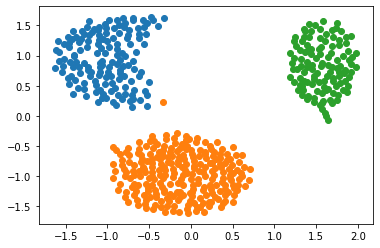

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


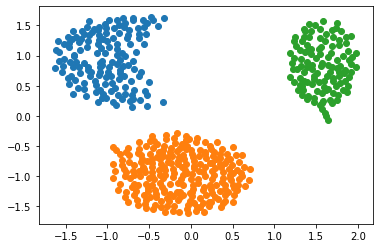

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


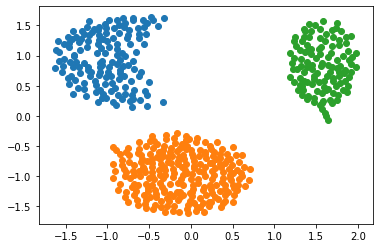

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


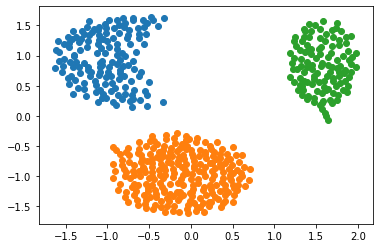

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


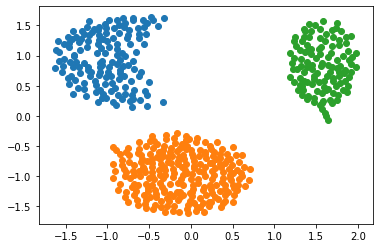

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


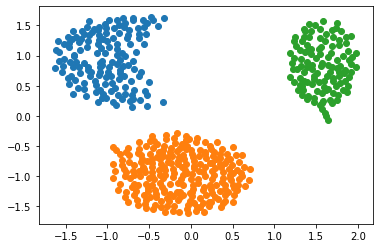

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


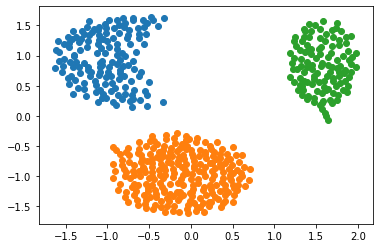

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


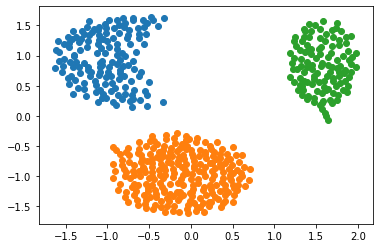

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


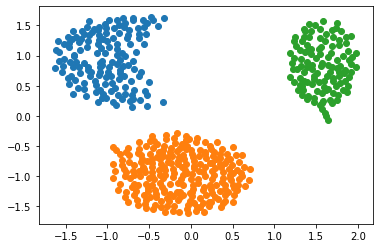

[-1.06167144  0.91395744]
[-0.09429986 -0.98706182]
[1.56246297 0.82343272]


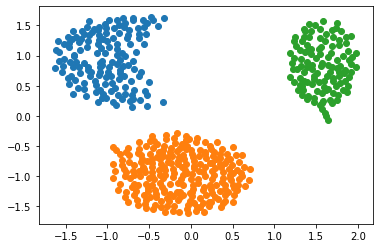

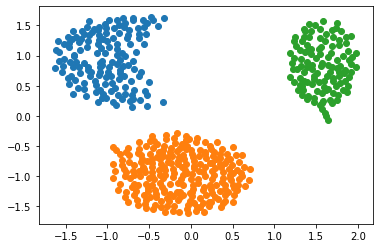

In [84]:
X_centroids, clusterMap = kmeans(3,X_treino, 10)

[1.438e+01 1.870e+00 2.380e+00 1.200e+01 1.020e+02 3.300e+00 3.640e+00
 2.900e-01 2.960e+00 7.500e+00 1.200e+00 3.000e+00 1.547e+03]
[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[ 12.43   1.53   2.29  21.5   86.     2.74   3.15   0.39   1.77   3.94
   0.69   2.84 352.  ]


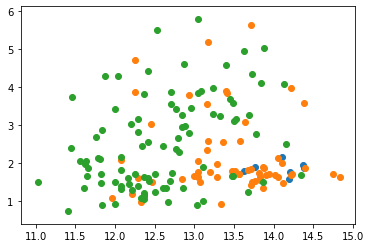

[1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
 2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
[1.368e+01 1.830e+00 2.360e+00 1.720e+01 1.040e+02 2.420e+00 2.690e+00
 4.200e-01 1.970e+00 3.840e+00 1.230e+00 2.870e+00 9.900e+02]
[1.22e+01 3.03e+00 2.32e+00 1.90e+01 9.60e+01 1.25e+00 4.90e-01 4.00e-01
 7.30e-01 5.50e+00 6.60e-01 1.83e+00 5.10e+02]


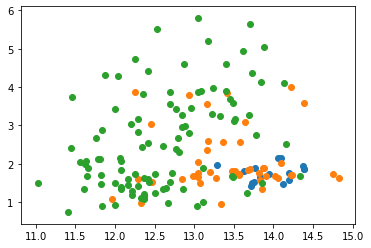

[1.363e+01 1.810e+00 2.700e+00 1.720e+01 1.120e+02 2.850e+00 2.910e+00
 3.000e-01 1.460e+00 7.300e+00 1.280e+00 2.880e+00 1.310e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


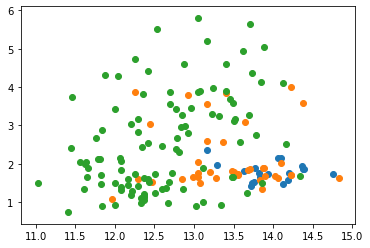

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


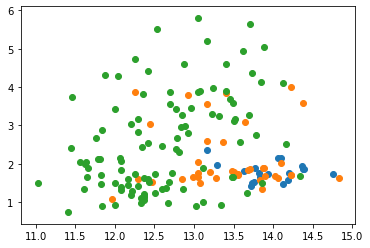

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


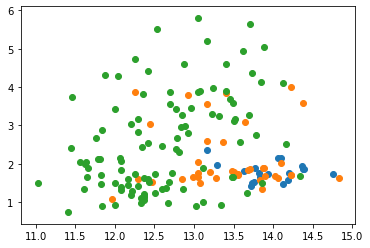

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


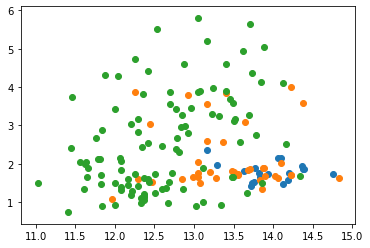

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


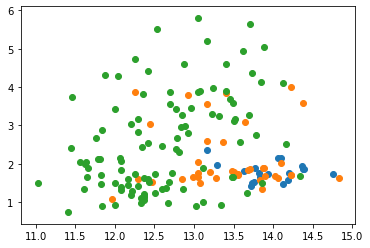

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


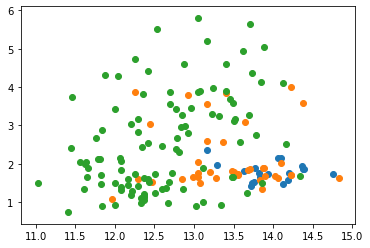

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


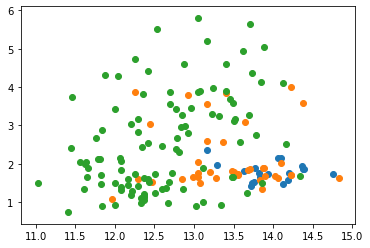

[1.372e+01 1.430e+00 2.500e+00 1.670e+01 1.080e+02 3.400e+00 3.670e+00
 1.900e-01 2.040e+00 6.800e+00 8.900e-01 2.870e+00 1.285e+03]
[1.39e+01 1.68e+00 2.12e+00 1.60e+01 1.01e+02 3.10e+00 3.39e+00 2.10e-01
 2.14e+00 6.10e+00 9.10e-01 3.33e+00 9.85e+02]
[1.184e+01 8.900e-01 2.580e+00 1.800e+01 9.400e+01 2.200e+00 2.210e+00
 2.200e-01 2.350e+00 3.050e+00 7.900e-01 3.080e+00 5.200e+02]


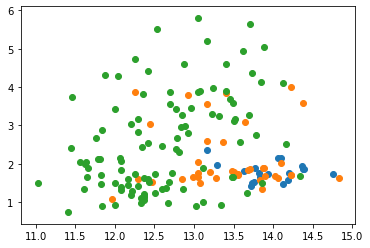

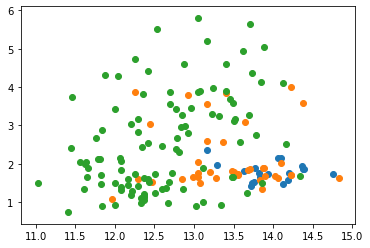

In [85]:
W_centroids, clusterMap = kmeans(3,W_treino, 10)

### Treinamento do Modelo Agglometrative Hierarchical Clustering


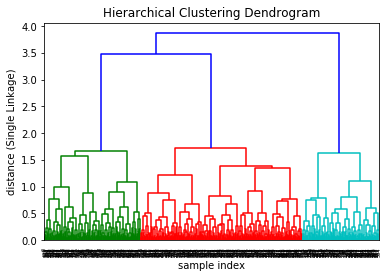

In [86]:
# Adicionar treinamento para a tarefa 2D
X_pointsMap = agglomerativeHierarchicalCluster(X_treino, 1, "complete")

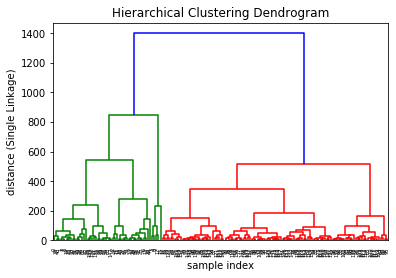

In [87]:
# Adicionar treinamento para a tarefa dos vinhos
W_pointsMap = agglomerativeHierarchicalCluster(W_treino, 1, "complete")

### Testando Modelo K-Means


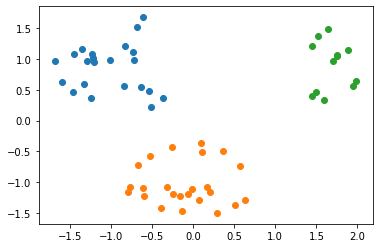

In [88]:
kmeans(3,X_teste, 10, 'test', X_centroids)

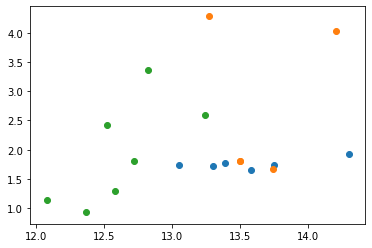

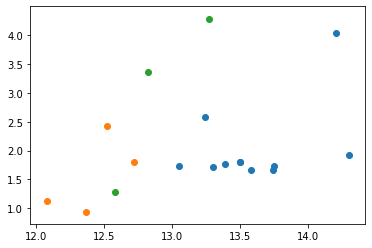

In [89]:
kmeans(3,W_teste, 10, 'test', W_centroids)
#aqui podemos calcular a taxa de acerto do modelo
plotGroundTruth(3, W_teste, W_teste_y)

### Testando Modelo Agglomerative Hierarchical Clustering

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0}


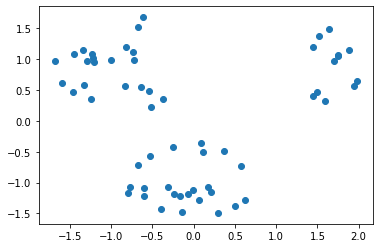

In [92]:
# Adicionar teste dos dados da tarefa 2D
X_pointsMap = agglomerativeHierarchicalCluster(X_treino, 3, "complete", False)
testPointsMap = testAgglomerativeHierarchicalCluster(X_teste, X_treino, X_pointsMap)
plotAggCluster(testPointsMap, X_teste)


In [ ]:
# Adicionar teste dos dados da tarefa dos vinhos
W_pointsMap = agglomerativeHierarchicalCluster(X_treino, 3, "complete", False)
testPointsMap = testAgglomerativeHierarchicalCluster(W_teste, W_treino, W_pointsMap)
plotAggCluster(testPointsMap, W_teste)
plotGroundTruth(3, W_teste, W_teste_y)

## Parte 2 - Redução de Dimensionalidade
Utilizamos o método PCA para reduzir a dimensionalidade da tarefa escolhida pelo grupo, e comparamos o efeito de aplicar o K-Means em um conjunto de dados sem redução de dimensionalidade e outro com redução de dimensionalidade.
Realizamos as seguintes tarefas:
<ul>
    <li>Rodamos o PCA nos dados, utilizando 3 energias (variâncias) diferentes para reduzir a dimensionalidade</li>
    <li>Rodamos o K-Means com diferentes números de clusteres</li>
    <li>Comparamos os resultados com os obtidos na Parte 1</li>
</ul>


### Rodando o PCA
Realizamos a análise de dimensionalidade utilizando-se dos dados de treino do dataset de vinhos, e obervarmos as propriedades mais relevantes para classificação dos itens.

Primeiramente, montamos um gráfico para explicar quais componentes principais são mais percentualmente relevantes à representação, ou seja, quais componentes explicam melhor nossos dados.


In [ ]:
pca = PCA()
pca_data = pca.fit_transform(W_treino)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ["PC" + str(i) for i in range(1, 14)]

plt.bar(x=range(1, 14), height=per_var, tick_label=labels)
plt.ylabel('Percentage of ExplainedVariance')
plt.xlabel('PCs')
plt.show()


Em seguida, montamos um dataFrame para organizar nossos dados e observar a projeção das componentes em apenas duas dimensões, para que seja mais fácil de avaliar suas relevâncias e similaridades.

É importante observar que features mais distantes da origem têm maior influência sobre os dados, como também, features próximas umas das outras nos revelam similaridade entre as mesmas.

In [ ]:
wine_labels = ['Alcohol', 'Malic acid', 'Ash', 'Alc. of ash', 'Magnesium', 'Total phenols', \
              'Flavanoids', 'Nonfl. phen.', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
              'Proline']
pca_df = pd.DataFrame(pca_data.T, index=wine_labels)


plt.scatter(pca_df[0], pca_df[1])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for idx in pca_df.index:
    plt.annotate(idx, (pca_df[0].loc[idx], pca_df[1].loc[idx]))

plt.show()

### Escolher 3 variâncias
Variância 1: PC1, PC2 e PC3 com 66.52% de representatividade <br>
Variância 2: PC1, PC2, PC3, PC4 e PC5 com 80.16% de representatividade <br>
Variância 3: PC1, PC2, PC3, PC4, PC5, PC6 e PC7 com 89.33% de representatividade <br>

In [ ]:
energy1 = 3
energy2 = 5
energy3 = 7

cluster_energy1 = []
cluster_energy2 = []
cluster_energy3 = []

elbowPlot(10, pca_data[:,:energy1])


## Discussão
<ul>
    <li>Como/se a normalização afetou nossos reultados</li>
    <li>Se o número de clusteres encontrado representa bem nossos dados</li>
    <li>Como/se a inicialização de "centroides" afeta a solução</li>
    <li>As desvantagens de cada método</li>
    <li>Como a redução de dimensionalidade afetou seus resultados</li>
</ul>